In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
# import Libraries
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F

# check if gpu is available(M1~3 macs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [13]:
# data directory to save the cifar10 dataset
data_dir = './data/cifar10'

In [ ]:
# define a transform to normalize the data
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                                      ])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [16]:
# Load the training and test datasets
# Data augmentation is only done on training images
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Batch size of 100 i.e to work with 100 images at a time
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [17]:
# classes in cifar10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
# 신경망 모델 정의
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 120)

        # #hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
        # For now I only say 120 there is no reason.

        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 120)
        self.fc4 = nn.Linear(120, 84)
        self.fc5 = nn.Linear(84, 10)  # 10 output classes

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [21]:
model = ANN().to(device) # run our model on cuda GPU for faster results
model

ANN(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
learning_rate = 0.001 #hyperparameter

# defining the loss function
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow

# selecting the optimizer and passing the parameters(model parameters are passed which we got above in net.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device) # input to device as our model is running in mentioned device.
        labels = labels.to(device)
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels.

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    else:
        with torch.no_grad(): # we do not need gradient for validation.
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ len(training_loader) # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.8198, acc 34.1660 
validation loss: 1.6028, validation acc 42.8100 
epoch : 2
training loss: 1.6325, acc 41.6940 
validation loss: 1.5214, validation acc 45.9100 
epoch : 3
training loss: 1.5537, acc 44.4620 
validation loss: 1.4751, validation acc 47.3400 
epoch : 4
training loss: 1.5036, acc 46.2400 
validation loss: 1.4355, validation acc 48.4200 
epoch : 5
training loss: 1.4703, acc 47.2980 
validation loss: 1.4097, validation acc 49.9500 
epoch : 6
training loss: 1.4382, acc 48.3760 
validation loss: 1.4070, validation acc 50.5300 
epoch : 7
training loss: 1.4152, acc 49.4540 
validation loss: 1.3744, validation acc 51.0500 
epoch : 8
training loss: 1.3908, acc 50.0640 
validation loss: 1.3702, validation acc 51.8600 
epoch : 9
training loss: 1.3672, acc 51.0800 
validation loss: 1.3609, validation acc 51.7600 
epoch : 10
training loss: 1.3538, acc 51.6280 
validation loss: 1.3266, validation acc 52.7300 
epoch : 11
training loss: 1.3388, acc 52.2220 
va

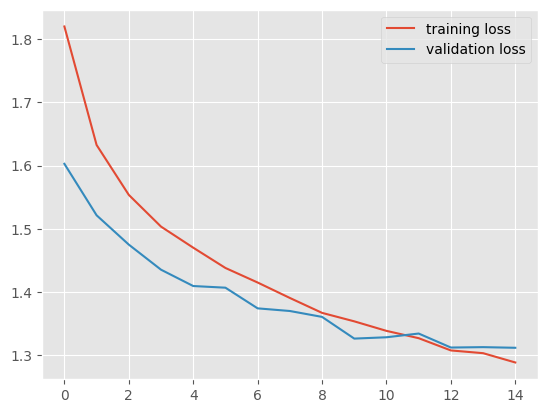

In [26]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [37]:
running_corrects_history_cpu = [x.cpu() for x in running_corrects_history]
val_running_corrects_history_cpu = [x.cpu() for x in val_running_corrects_history]

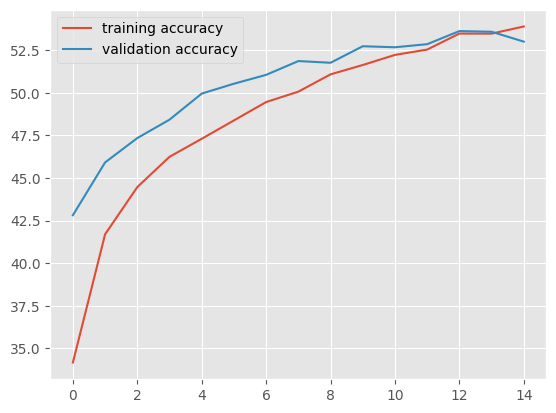

In [39]:
plt.style.use('ggplot')
plt.plot(running_corrects_history_cpu, label='training accuracy')
plt.plot(val_running_corrects_history_cpu, label='validation accuracy')
plt.legend()

In [45]:
import PIL.ImageOps
import requests
from PIL import Image

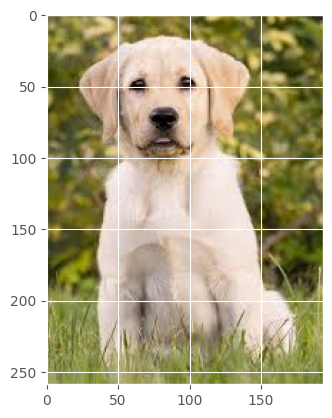

In [50]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT76mSMtKQWGstcqGi-0kPWJyVBqz8RCp8SuplMipkidRY0z9Mc&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

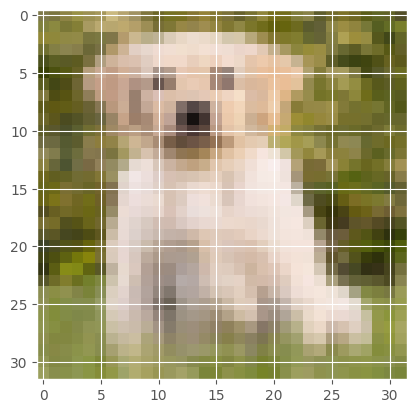

In [51]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

img = transform(img)  # applying the transformations on new image as our model has been trained on these transformations
plt.imshow(im_convert(img)) # convert to numpy array for plt

In [52]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog
